<a href="https://colab.research.google.com/github/isque03/deeplearning_colab/blob/main/timeseries3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install yfinance
import yfinance as yf
import IPython
import IPython.display
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

symbol = yf.Ticker('SPY')
#metl = yf.Ticker('IGE')
#metl_df = metl.history(period="max", interval='1d',auto_adjust=True)
#debt = yf.Ticker('SHY')
#debt_df = debt.history(period="max", interval='1d',auto_adjust=True)
#df.reset_index(inplace=True)
df = symbol.history(period="max", interval='1d',auto_adjust=True)
#df = yf.download("SPY SHY UUP DBB IGE GLD SLV XLU", start="2002-01-01", interval='1d')
df.reset_index(inplace=True)
print('Number of rows and columns:', df.shape)


     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 6.4 MB 7.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Number of rows and columns: (7313, 8)


In [3]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1993-01-29,25.645573,25.645573,25.517983,25.627346,1003200,0.0,0
1,1993-02-01,25.645576,25.809620,25.645576,25.809620,480500,0.0,0
2,1993-02-02,25.791389,25.882525,25.736708,25.864298,201300,0.0,0
3,1993-02-03,25.900750,26.155930,25.882523,26.137703,529400,0.0,0
4,1993-02-04,26.228845,26.301754,25.937211,26.247072,531500,0.0,0


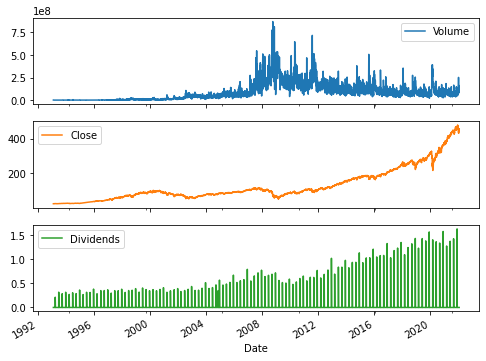

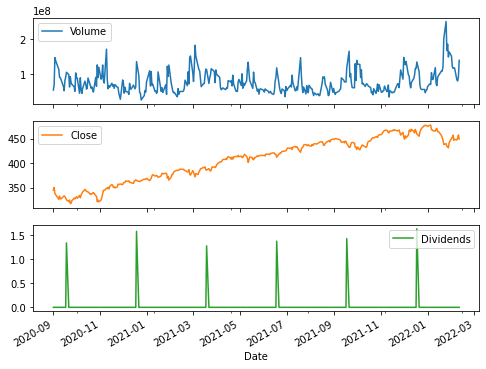

In [4]:
mpl.rcParams['figure.figsize'] = (8, 6)
plot_cols = ['Volume', 'Close', 'Dividends']
plot_features = df[plot_cols]
plot_features.index = df["Date"]
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][-365:]
plot_features.index = df["Date"][-365:]
_ = plot_features.plot(subplots=True)

In [5]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    

In [6]:
# Naive Forecasting
split_time = 3500
x_train = df[:split_time]
x_valid = df[split_time:]

In [7]:
naive_forecast = df[split_time - 1:-1]

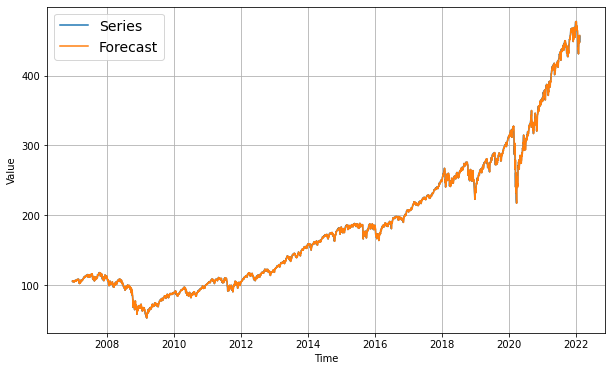

In [8]:
plt.figure(figsize=(10, 6))
plot_series(x_valid['Date'], x_valid['Close'], label="Series")
plot_series(x_valid['Date'], naive_forecast['Close'], label="Forecast")

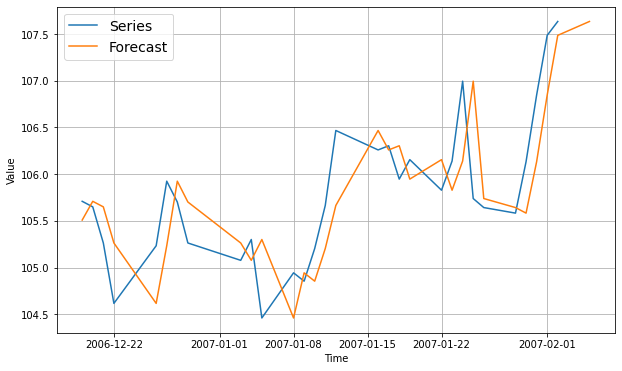

In [9]:
# zoom in
plt.figure(figsize=(10, 6))
plot_series(x_valid['Date'], x_valid['Close'], start=0, end=30, label="Series")
plot_series(x_valid['Date'], naive_forecast['Close'], start=0, end=31, label="Forecast")

In [10]:
# get baseline MAE and MPE
errors = naive_forecast['Close'].values - x_valid['Close'].values
abs_errors = np.abs(errors)
mae = abs_errors.mean()
mae
#errors
#naive_forecast['Close'][:1].values - x_valid['Close'][:1].values

1.3645393157486774

In [11]:
tf.keras.metrics.mean_absolute_error(naive_forecast['Close'],x_valid['Close']).numpy()

1.3645393157486774

In [12]:
tf.keras.metrics.mean_absolute_percentage_error(naive_forecast['Close'],x_valid['Close']).numpy()

0.798280759088591

In [13]:
def slow_impl_moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

In [14]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast
     This implementation is *much* faster than the previous one"""
  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size - 1:-1] / window_size

3813
3813


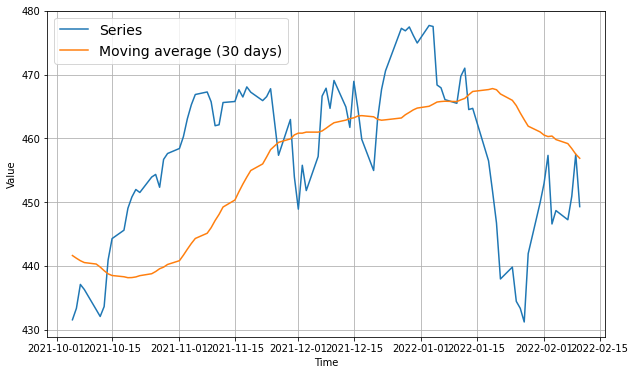

In [15]:
series = df['Close'].values
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]
print(len(moving_avg))
print(len(x_valid))
plt.figure(figsize=(10, 6))
zoom = 90
plot_series(x_valid['Date'][-zoom:], x_valid['Close'][-zoom:], label="Series")
plot_series(x_valid['Date'][-zoom:], moving_avg[-zoom:], label="Moving average (30 days)")

In [16]:
tf.keras.metrics.mean_absolute_percentage_error(moving_avg,x_valid['Close']).numpy()

2.5355716276131144

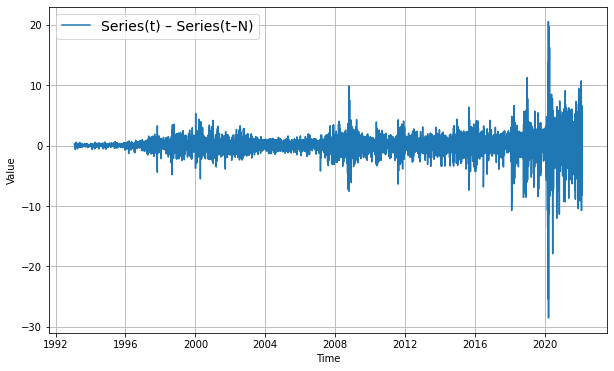

In [17]:
# apply differencing
difference = 1
diff_series = (series[difference:] - series[:-difference])
diff_time = df['Date'].values[difference:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series, label="Series(t) – Series(t–N)")
plt.show()

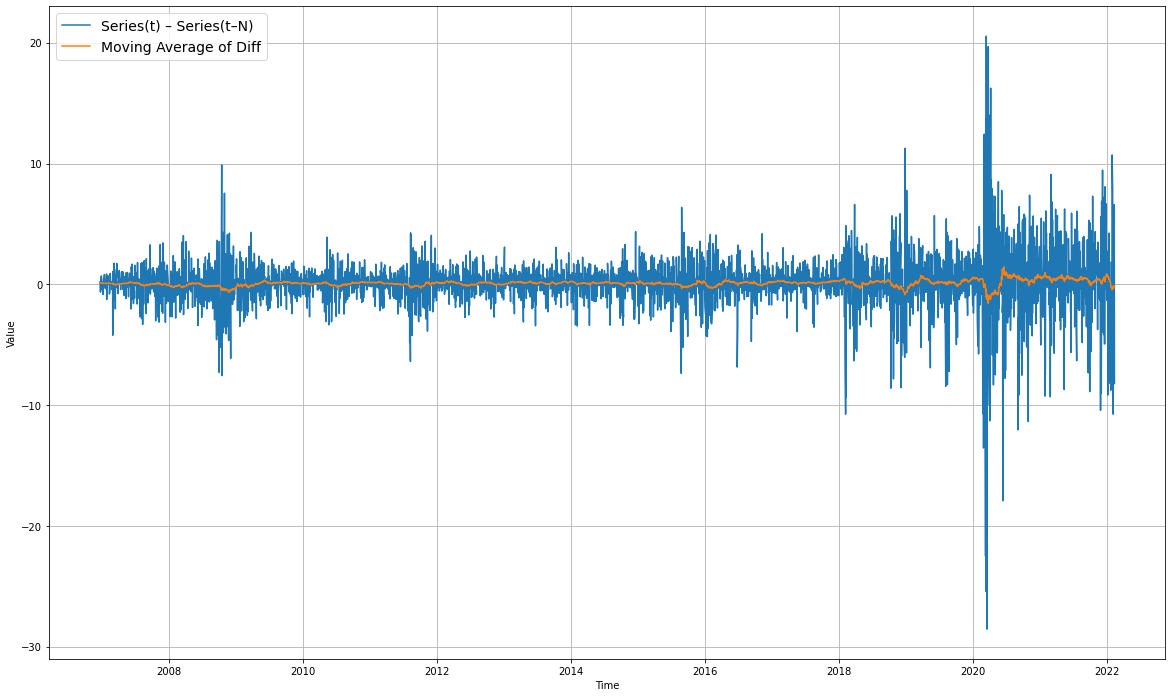

In [18]:
diff_moving_avg = moving_average_forecast(diff_series, 60)[split_time - difference - 60:]

plt.figure(figsize=(20, 12))
plot_series(x_valid['Date'], diff_series[split_time - difference:], label="Series(t) – Series(t–N)")
plot_series(x_valid['Date'], diff_moving_avg, label="Moving Average of Diff")
plt.show()

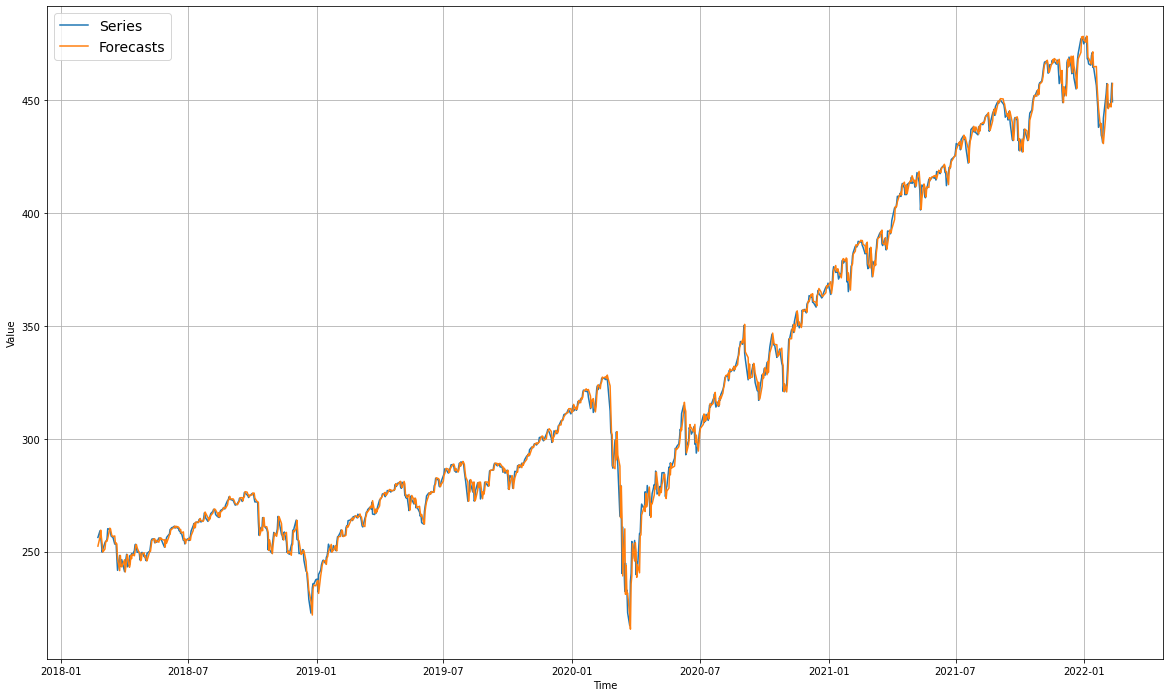

In [19]:
# Now let's bring back the trend and seasonality by adding the past values from t – 1:
diff_moving_avg_plus_past = series[split_time - 1:-1]  + diff_moving_avg

plt.figure(figsize=(20,12))
zoom = 1000
plot_series(x_valid['Date'][-zoom:], x_valid['Close'][-zoom:], label="Series")
plot_series(x_valid['Date'][-zoom:], diff_moving_avg_plus_past[-zoom:], label="Forecasts")
plt.show()

In [20]:
tf.keras.metrics.mean_absolute_percentage_error(diff_moving_avg_plus_past,x_valid['Close']).numpy()

0.8036819734425124

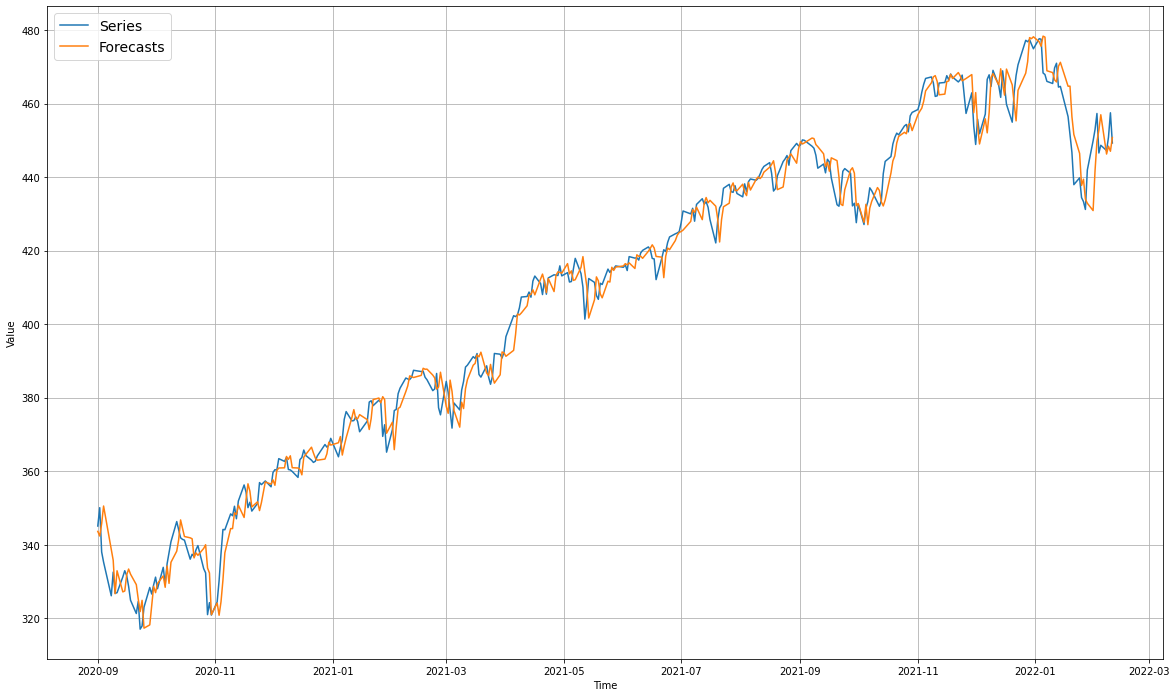

In [21]:
# smooth the past
#len(moving_average_forecast(series[split_time -6 : -1],5))
#len(diff_moving_avg)
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time -1 - 1:-1], 1) + diff_moving_avg

plt.figure(figsize=(20, 12))
zoom = 365
plot_series(x_valid['Date'][-zoom:], x_valid['Close'][-zoom:], label="Series")
plot_series(x_valid['Date'][-zoom:], diff_moving_avg_plus_smooth_past[-zoom:], label="Forecasts")
plt.show()

In [22]:
tf.keras.metrics.mean_absolute_percentage_error(diff_moving_avg_plus_smooth_past,x_valid['Close']).numpy()

1.113295200551547

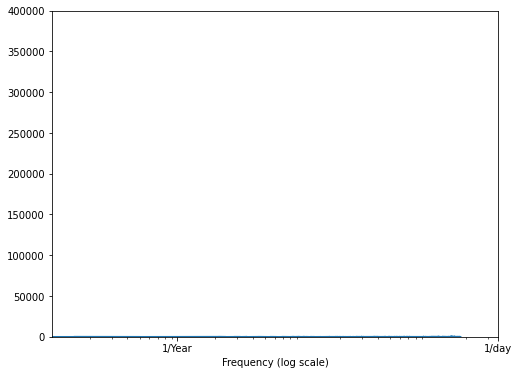

In [23]:
# check FFT signal
fft = tf.signal.rfft(diff_series)
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(diff_series)
days_per_year = 365.2524
years_per_dataset = n_samples_h/(days_per_year)
f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

[0 1 2 3 4 5 6 7 8 9]
[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5]
[3.5 4.5 5.5 6.5 7.5]


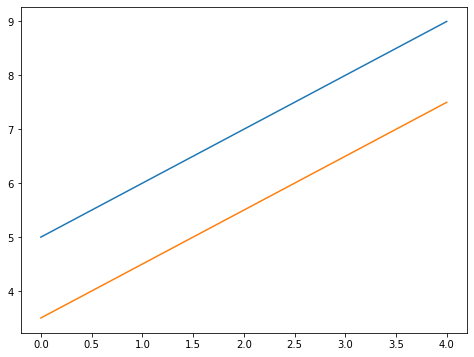

[7 8]
[0, 1, 2, 3, 4, 5, 6, 7]


In [24]:
vals = np.array([x for x in range(10)])
print(vals)
window = 2
ma = slow_impl_moving_average_forecast(vals,window)
print(ma)
len(ma)
len(vals)
split=5
train=vals[split:]
print(ma[split - window  :])
plt.plot(train)
plt.plot(ma[split - window:])
plt.show()
print(vals[7:7+window])
time = [x for x in range(len(vals) - window)]
print(time)

Text(0.5, 1.0, 'Day of year signal')

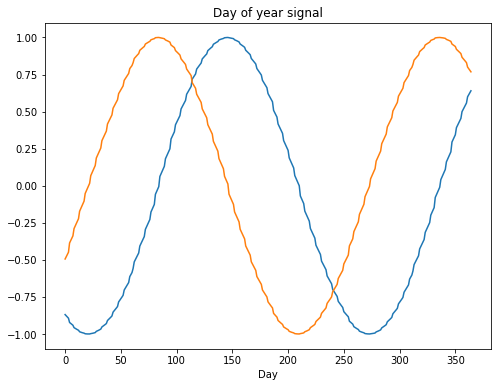

In [25]:
# see if date is useful for seasonality. convert to sin/cos
#
# convert datetime to seconds
timestamp_s = df['Date'].map(pd.Timestamp.timestamp)
# convert to period with sin function
day = 24*60*60
year = (365.2425)*day
# we don't have time of day since this is daily data
#df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
#df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(df['Year sin'])[-365:])
plt.plot(np.array(df['Year cos'])[-365:])
plt.xlabel('Day')
plt.title('Day of year signal')

In [26]:
# Try to beat moving avg with RNN
# RNN expects batch,timesteps,series 3D input



n = len(df)
df_sub = df[['Close','Volume','Year cos','Year sin']]
column_indices = {name: i for i, name in enumerate(df_sub.columns)}
train_df = df_sub[0:int(n*0.7)]
val_df = df_sub[int(n*0.7):int(n*0.9)]
test_df = df_sub[int(n*0.9):]

num_features = df_sub.shape[1]
column_indices

{'Close': 0, 'Volume': 1, 'Year cos': 2, 'Year sin': 3}

In [27]:
train_mean = train_df.mean()
train_std = train_df.std()
#train_df[['Close','Volume','Year cos','Year sin']]
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

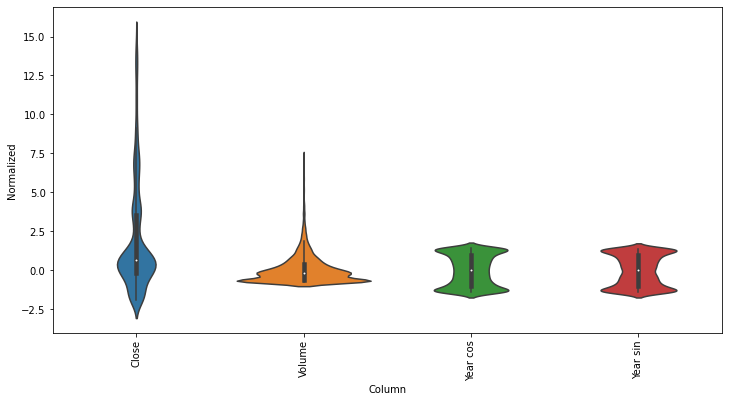

In [28]:
df_std = (df_sub - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df_sub.keys(), rotation=90)

In [29]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    return inputs, labels

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds
  
  def plot(self, model=None, plot_col='Close', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time')

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result


In [30]:
w1 = WindowGenerator(input_width=4, label_width=1, shift=4,
                     label_columns=['Close'])
w1

Total window size: 8
Input indices: [0 1 2 3]
Label indices: [7]
Label column name(s): ['Close']

In [31]:
w2 = WindowGenerator(input_width=30, label_width=1, shift=1,
                     label_columns=['Close'])
w2

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['Close']

In [32]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 31, 4)
Inputs shape: (3, 30, 4)
Labels shape: (3, 1, 1)


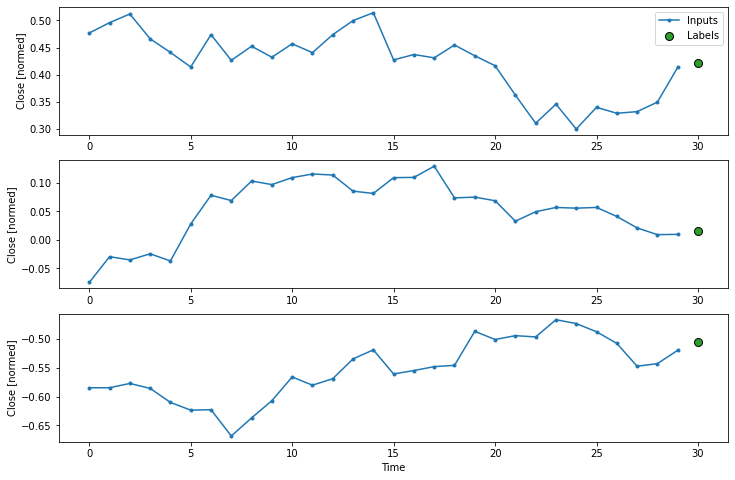

In [33]:
w2.plot()

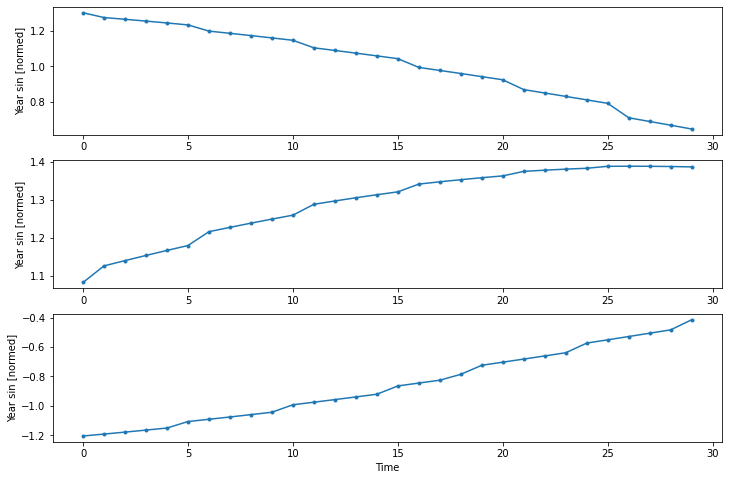

In [34]:
w2.plot(plot_col='Year sin')

In [35]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 30, 4), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [36]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 30, 4)
Labels shape (batch, time, features): (32, 1, 1)


In [37]:
# predict 1 step (day) into the future (1 step)
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Close'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Close']

In [38]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 4)
Labels shape (batch, time, features): (32, 1, 1)


In [39]:
# Work on baseline prediction (temp an hour from now will be the same as now)
# did this above with numpy
'''
In the __init__() method, define the layers the model will use.

In the call() method, define the forward pass of the model, reusing the layers previously created.

Instantiate your subclass, and call it on data to create its weights.
'''
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [40]:
# column_indicies is a map created above from df.columns
baseline = Baseline(label_index=column_indices['Close'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsolutePercentageError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

46/46 [==============================] - 1s 7ms/step - loss: 0.0038 - mean_absolute_percentage_error: 0.9672


In [41]:
# make a wider window to view data better
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Close'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Close']

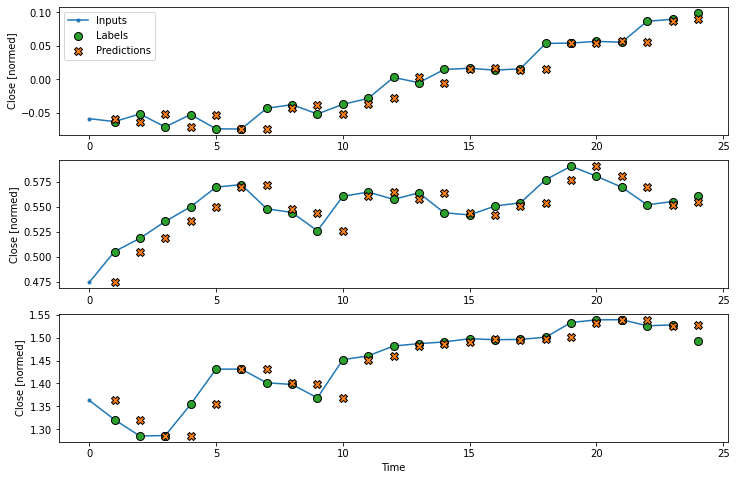

In [42]:
wide_window.plot(baseline)

In [43]:
# a dense model with no activation function is linear
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 4)
Output shape: (32, 1, 1)


In [44]:
MAX_EPOCHS = 300

def compile_and_fit(model, window, patience=40, checkpoint_name="my_checkpoint.h5"):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_percentage_error',
                                                    patience=patience,
                                                    mode='min')
  lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
  #optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
  adam_optimizer = tf.optimizers.Adam()
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=adam_optimizer,
                metrics=[tf.metrics.MeanAbsolutePercentageError()])
  model_checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_name, save_best_only=True)
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping,model_checkpoint])
  return history

In [45]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/300
160/160 [==============================] - 2s 10ms/step - loss: 2.9663 - mean_absolute_percentage_error: 519.1397 - val_loss: 45.9514 - val_mean_absolute_percentage_error: 142.8744
Epoch 2/300
160/160 [==============================] - 2s 9ms/step - loss: 2.1637 - mean_absolute_percentage_error: 395.2314 - val_loss: 36.9673 - val_mean_absolute_percentage_error: 127.8920
Epoch 3/300
160/160 [==============================] - 1s 6ms/step - loss: 1.5736 - mean_absolute_percentage_error: 304.7430 - val_loss: 29.5448 - val_mean_absolute_percentage_error: 114.0698
Epoch 4/300
160/160 [==============================] - 1s 6ms/step - loss: 1.1477 - mean_absolute_percentage_error: 241.3363 - val_loss: 23.4240 - val_mean_absolute_percentage_error: 101.2996
Epoch 5/300
160/160 [==============================] - 1s 6ms/step - loss: 0.8449 - mean_absolute_percentage_error: 193.6194 - val_loss: 18.4463 - val_mean_absolute_percentage_error: 89.6465
Epoch 6/300
160/160 [===================

In [46]:
#plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-6, 1e-3, 0, .01])
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 4)
Output shape: (32, 24, 1)


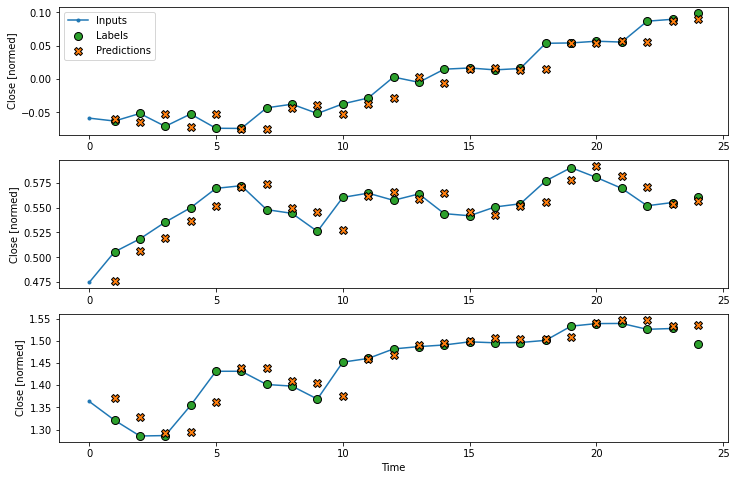

In [47]:
wide_window.plot(linear)

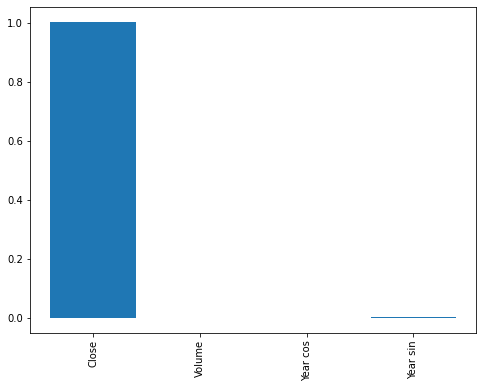

In [48]:
# visualize the layer weights in the linear model above
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [49]:
# Try Dense
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/300
160/160 [==============================] - 2s 8ms/step - loss: 0.0675 - mean_absolute_percentage_error: 64.8189 - val_loss: 0.0167 - val_mean_absolute_percentage_error: 2.2662
Epoch 2/300
160/160 [==============================] - 1s 7ms/step - loss: 0.0020 - mean_absolute_percentage_error: 24.5359 - val_loss: 0.0095 - val_mean_absolute_percentage_error: 1.6710
Epoch 3/300
160/160 [==============================] - 1s 7ms/step - loss: 0.0017 - mean_absolute_percentage_error: 20.2943 - val_loss: 0.0151 - val_mean_absolute_percentage_error: 2.1317
Epoch 4/300
160/160 [==============================] - 1s 7ms/step - loss: 0.0017 - mean_absolute_percentage_error: 22.9665 - val_loss: 0.0148 - val_mean_absolute_percentage_error: 2.1340
Epoch 5/300
160/160 [==============================] - 1s 7ms/step - loss: 0.0017 - mean_absolute_percentage_error: 25.2631 - val_loss: 0.0269 - val_mean_absolute_percentage_error: 2.9699
Epoch 6/300
160/160 [==============================] - 1s 7m

In [50]:
# multi time step dense. single time step can't see how features change over time
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Close'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Close']

Text(0.5, 1.0, 'Given 3 days of inputs, predict 1 day into the future.')

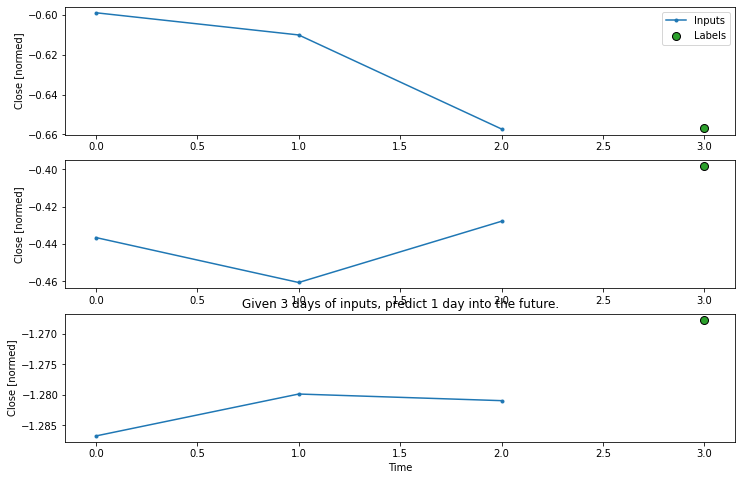

In [51]:
conv_window.plot()
plt.title("Given 3 days of inputs, predict 1 day into the future.")

In [52]:
# You could train a dense model on a multiple-input-step window by adding a tf.keras.layers.Flatten as the first layer of the model:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [53]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 4)
Output shape: (32, 1, 1)


In [54]:
history = compile_and_fit(multi_step_dense, conv_window)
model = keras.models.load_model("my_checkpoint.h5")


Epoch 1/300
160/160 [==============================] - 2s 7ms/step - loss: 0.1015 - mean_absolute_percentage_error: 89.2725 - val_loss: 0.3026 - val_mean_absolute_percentage_error: 9.9874
Epoch 2/300
160/160 [==============================] - 1s 6ms/step - loss: 0.0053 - mean_absolute_percentage_error: 46.7743 - val_loss: 0.1760 - val_mean_absolute_percentage_error: 7.2026
Epoch 3/300
160/160 [==============================] - 1s 6ms/step - loss: 0.0035 - mean_absolute_percentage_error: 38.2825 - val_loss: 0.1548 - val_mean_absolute_percentage_error: 6.7871
Epoch 4/300
160/160 [==============================] - 1s 6ms/step - loss: 0.0030 - mean_absolute_percentage_error: 28.1714 - val_loss: 0.1205 - val_mean_absolute_percentage_error: 5.9464
Epoch 5/300
160/160 [==============================] - 1s 6ms/step - loss: 0.0027 - mean_absolute_percentage_error: 28.0735 - val_loss: 0.1203 - val_mean_absolute_percentage_error: 6.0742
Epoch 6/300
160/160 [==============================] - 1s 6m

In [55]:
IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

46/46 [==============================] - 0s 4ms/step - loss: 0.0078 - mean_absolute_percentage_error: 1.5222


In [56]:
# The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape.
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 4)

ValueError:Exception encountered when calling layer "sequential_2" (type Sequential).

Input 0 of layer "dense_5" is incompatible with the layer: expected axis -1of input shape to have value 12, but received input with shape (32, 96)

Call arguments received:
  • inputs=tf.Tensor(shape=(32, 24, 4), dtype=float32)
  • training=None
  • mask=None


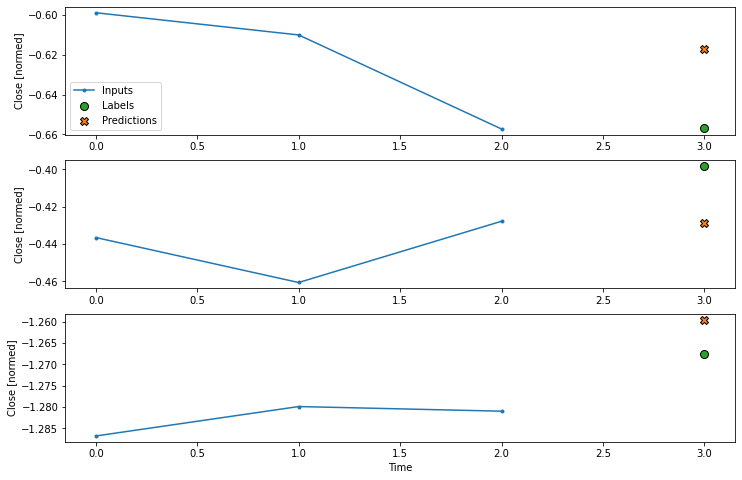

In [57]:
conv_window.plot(model)

In [58]:
'''
The convolutional models in the next section fix this problem.

Convolution neural network
A convolution layer (tf.keras.layers.Conv1D) also takes multiple time steps as input to each prediction.

Below is the same model as multi_step_dense, re-written with a convolution.

Note the changes:

The tf.keras.layers.Flatten and the first tf.keras.layers.Dense are replaced by a tf.keras.layers.Conv1D.
The tf.keras.layers.Reshape is no longer necessary since the convolution keeps the time axis in its output.
'''

'\nThe convolutional models in the next section fix this problem.\n\nConvolution neural network\nA convolution layer (tf.keras.layers.Conv1D) also takes multiple time steps as input to each prediction.\n\nBelow is the same model as multi_step_dense, re-written with a convolution.\n\nNote the changes:\n\nThe tf.keras.layers.Flatten and the first tf.keras.layers.Dense are replaced by a tf.keras.layers.Conv1D.\nThe tf.keras.layers.Reshape is no longer necessary since the convolution keeps the time axis in its output.\n'

In [59]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [60]:
# Run it on an example batch to check that the model produces outputs with the expected shape:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 4)
Output shape: (32, 1, 1)


In [ ]:
# Train and evaluate it on the conv_window and it should give performance similar to the multi_step_dense model.
history = compile_and_fit(conv_model, conv_window)
#conv_model = keras.models.load_model("my_checkpoint.h5")
IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

Epoch 1/300
160/160 [==============================] - 9s 8ms/step - loss: 0.1359 - mean_absolute_percentage_error: 95.5080 - val_loss: 1.7782 - val_mean_absolute_percentage_error: 25.5159
Epoch 2/300
160/160 [==============================] - 1s 7ms/step - loss: 0.0052 - mean_absolute_percentage_error: 45.1306 - val_loss: 0.7186 - val_mean_absolute_percentage_error: 15.5339
Epoch 3/300
160/160 [==============================] - 1s 7ms/step - loss: 0.0032 - mean_absolute_percentage_error: 34.7173 - val_loss: 0.4808 - val_mean_absolute_percentage_error: 12.4987
Epoch 4/300
160/160 [==============================] - 1s 7ms/step - loss: 0.0027 - mean_absolute_percentage_error: 34.6621 - val_loss: 0.3338 - val_mean_absolute_percentage_error: 10.1840
Epoch 5/300
160/160 [==============================] - 1s 7ms/step - loss: 0.0025 - mean_absolute_percentage_error: 34.2980 - val_loss: 0.2896 - val_mean_absolute_percentage_error: 9.4454
Epoch 6/300
160/160 [==============================] - 1

In [ ]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

In [ ]:
'''
Note that the output is shorter than the input. 
To make training or plotting work, you need the labels, and prediction to have the same length. 
So build a WindowGenerator to produce wide windows with a few extra input time steps so the label
and prediction lengths match:
'''
LABEL_WIDTH = 20
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Close'])

wide_conv_window

In [ ]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

In [ ]:
# 
# Now, you can plot the model's predictions on a wider window. Note the 3 input time steps before
# the first prediction. Every prediction here is based on the 3 preceding time steps:
#
wide_conv_window.plot(conv_model)

In [ ]:
# With return_sequences=True, the model can be trained on 24 hours of data at a time.
# Note: This will give a pessimistic view of the model's performance. On the first time step, 
# the model has no access to previous steps and, therefore, can't do any better than the simple
# linear and dense models shown earlier.
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

In [ ]:
history = compile_and_fit(lstm_model, wide_window, checkpoint_name='LSTM.h5')
lstm_model = keras.models.load_model("LSTM.h5")
IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

In [ ]:
fully_conv_model = keras.models.Sequential()
fully_conv_model.add(keras.layers.InputLayer(input_shape=[None,4]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    fully_conv_model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=(CONV_WIDTH,),
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
fully_conv_model.add(keras.layers.Conv1D(filters=1, kernel_size=1))


In [ ]:
# can we load to continue from last time?
fully_conv_model = keras.models.load_model("FCONV.h5")
history = compile_and_fit(fully_conv_model, wide_window, checkpoint_name='FCONV.h5')
# if it got any better, load this
fully_conv_model = keras.models.load_model("FCONV.h5")
IPython.display.clear_output()
val_performance['FCONV'] = fully_conv_model.evaluate(wide_window.val)
performance['FCONV'] = fully_conv_model.evaluate(wide_window.test, verbose=0)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', fully_conv_model(wide_window.example[0]).shape)
wide_conv_window.plot(fully_conv_model)